<a href="https://colab.research.google.com/github/2303A51272/pythonDS/blob/main/pyp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Re-run with lighter settings to complete within time limits
import os, zipfile, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    from sklearn.ensemble import RandomForestClassifier
    XGB_AVAILABLE = False
from sklearn.neural_network import MLPClassifier
# import caas_jupyter_tools # Removed unavailable module

data_path = "/content/synthetic_student_performance.csv"
out_dir = "/mnt/data/student_model_outputs_fast"
os.makedirs(out_dir, exist_ok=True)

df = pd.read_csv(data_path)
X = df.drop(columns=["StudentID", "GPA", "GradeClass"])
y = df["GradeClass"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fast Tree model
if XGB_AVAILABLE:
    xgb = XGBClassifier(
        eval_metric="mlogloss",
        random_state=42,
        n_estimators=150,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        learning_rate=0.1,
        tree_method="hist"
    )
else:
    from sklearn.ensemble import RandomForestClassifier
    xgb = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
proba_xgb = xgb.predict_proba(X_test) if hasattr(xgb, "predict_proba") else None
report_xgb = classification_report(y_test, y_pred_xgb, output_dict=True)

# Confusion matrix plot (Tree)
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix - Tree Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.tight_layout()
cm_tree_path = os.path.join(out_dir, "cm_tree.png")
plt.savefig(cm_tree_path)
plt.close()

# Feature importance (top 10) if available
fi_path = None
if hasattr(xgb, "feature_importances_"):
    importances = xgb.feature_importances_
    idx = np.argsort(importances)[::-1][:10]
    plt.figure()
    plt.bar(range(len(idx)), importances[idx])
    plt.xticks(range(len(idx)), X.columns[idx], rotation=45, ha="right")
    plt.title("Top 10 Feature Importances (Tree Model)")
    plt.tight_layout()
    fi_path = os.path.join(out_dir, "feature_importance_top10.png")
    plt.savefig(fi_path)
    plt.close()

# MLP (DNN-like) fast
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=60,
    random_state=42,
    learning_rate_init=1e-3,
    batch_size=64,
    verbose=False
)
mlp.fit(X_train_s, y_train)
y_pred_mlp = mlp.predict(X_test_s)
proba_mlp = mlp.predict_proba(X_test_s)
report_mlp = classification_report(y_test, y_pred_mlp, output_dict=True)

# Confusion matrix plot (MLP)
cm = confusion_matrix(y_test, y_pred_mlp)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.tight_layout()
cm_mlp_path = os.path.join(out_dir, "cm_mlp.png")
plt.savefig(cm_mlp_path)
plt.close()

# Hybrid ensemble
classes_ = np.unique(y_train)
def proba_in_order(model_proba, model_classes, target_classes):
    proba_ordered = np.zeros((model_proba.shape[0], len(target_classes)))
    for i, c in enumerate(target_classes):
        idx = np.where(model_classes == c)[0][0]
        proba_ordered[:, i] = model_proba[:, idx]
    return proba_ordered

proba_xgb_ord = proba_in_order(proba_xgb, xgb.classes_, classes_) if proba_xgb is not None else None
proba_mlp_ord = proba_in_order(proba_mlp, mlp.classes_, classes_)

if proba_xgb_ord is not None:
    ens_proba = 0.5 * proba_xgb_ord + 0.5 * proba_mlp_ord
    y_pred_ens = classes_[np.argmax(ens_proba, axis=1)]
    report_ens = classification_report(y_test, y_pred_ens, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_ens)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix - Hybrid")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.colorbar()
    plt.tight_layout()
    cm_ens_path = os.path.join(out_dir, "cm_ens.png")
    plt.savefig(cm_ens_path)
    plt.close()
else:
    y_pred_ens = y_pred_mlp
    report_ens = report_mlp
    cm_ens_path = cm_mlp_path

# Results table
def row(name, rep):
    return dict(Model=name,
                Accuracy=rep["accuracy"],
                Precision_w=rep["weighted avg"]["precision"],
                Recall_w=rep["weighted avg"]["recall"],
                F1_w=rep["weighted avg"]["f1-score"])

results = [
    row("XGBoost" if XGB_AVAILABLE else "RandomForest", report_xgb),
    row("MLP (DNN)", report_mlp),
    row("Hybrid", report_ens)
]
results_df = pd.DataFrame(results)
results_csv = os.path.join(out_dir, "results_summary.csv")
results_df.to_csv(results_csv, index=False)

# Show table to user
display(results_df) # Replaced caas_jupyter_tools.display_dataframe_to_user with display

# Zip outputs
zip_path = "/mnt/data/student_results_fast.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    zf.write(results_csv, arcname="results_summary.csv")
    zf.write(cm_tree_path, arcname=os.path.basename(cm_tree_path))
    zf.write(cm_mlp_path, arcname=os.path.basename(cm_mlp_path))
    zf.write(cm_ens_path, arcname=os.path.basename(cm_ens_path))
    if fi_path:
        zf.write(fi_path, arcname=os.path.basename(fi_path))

zip_path

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Accuracy,Precision_w,Recall_w,F1_w
0,XGBoost,0.464,0.403252,0.464,0.408914
1,MLP (DNN),0.449,0.396919,0.449,0.411041
2,Hybrid,0.466,0.397939,0.466,0.409686


'/mnt/data/student_results_fast.zip'

Confusion Matrix - Tree Model:


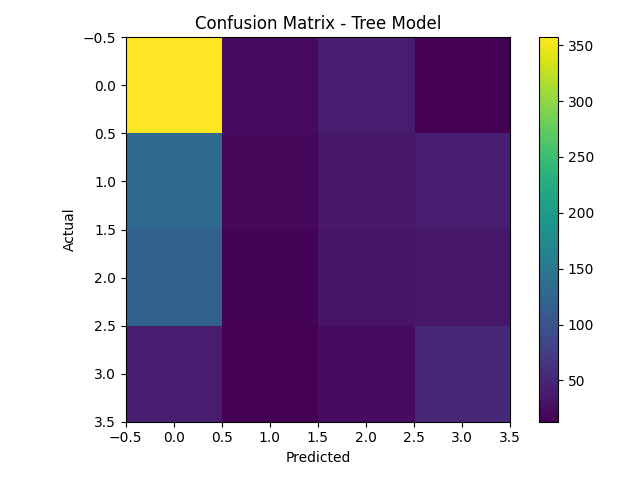


Confusion Matrix - MLP:


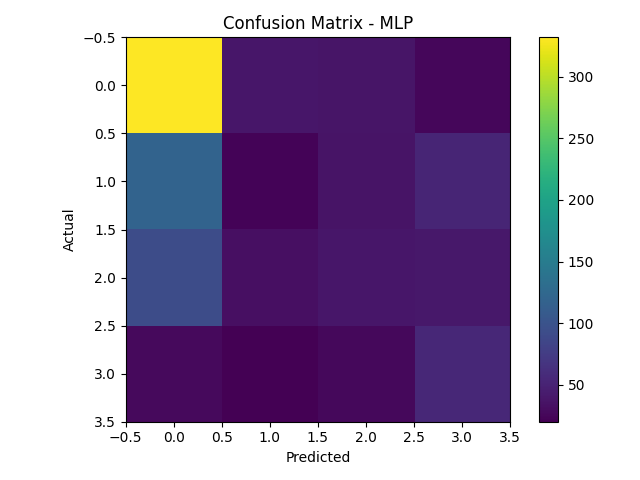


Confusion Matrix - Hybrid:


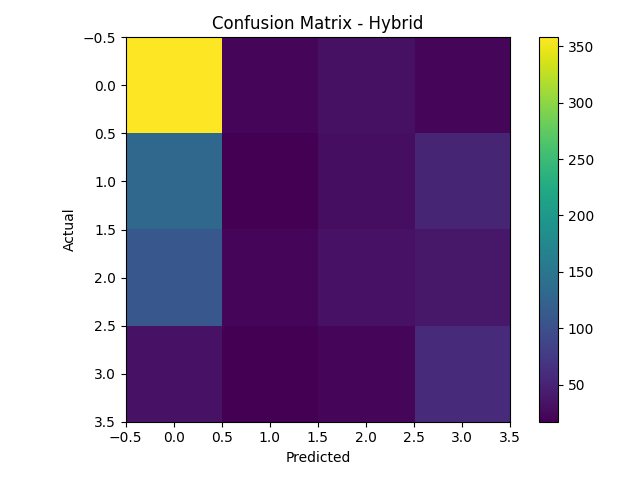


Top 10 Feature Importances (Tree Model):


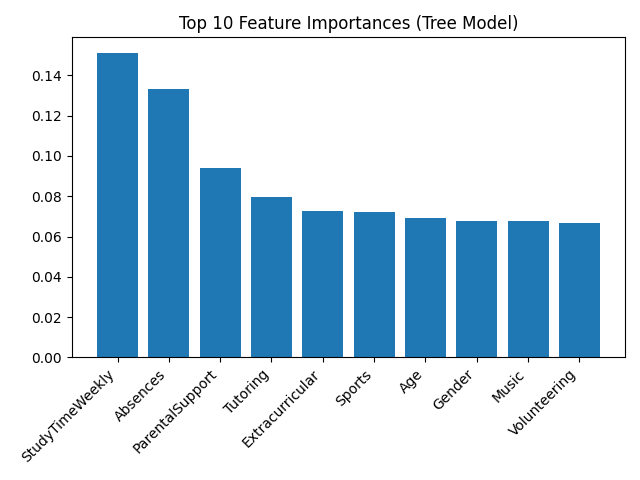

In [12]:
from IPython.display import Image, display
import os

out_dir = "/mnt/data/student_model_outputs_fast"

print("Confusion Matrix - Tree Model:")
display(Image(filename=os.path.join(out_dir, "cm_tree.png")))

print("\nConfusion Matrix - MLP:")
display(Image(filename=os.path.join(out_dir, "cm_mlp.png")))

# Check if hybrid confusion matrix was generated (only if XGBoost was available)
cm_ens_path = os.path.join(out_dir, "cm_ens.png")
if os.path.exists(cm_ens_path):
    print("\nConfusion Matrix - Hybrid:")
    display(Image(filename=cm_ens_path))
else:
    print("\nHybrid Confusion Matrix was not generated (XGBoost not available).")


# Check if feature importance plot was generated
fi_path = os.path.join(out_dir, "feature_importance_top10.png")
if os.path.exists(fi_path):
    print("\nTop 10 Feature Importances (Tree Model):")
    display(Image(filename=fi_path))
else:
    print("\nFeature importance plot was not generated (Tree model does not have feature_importances_).")